In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Loading Data

In [2]:
# choose a list of 35 countries to train global model
countries = ['Germany', 'France', 'Australia', 'Brazil', 'Italy', 'Spain',
       'Canada', 'Netherlands', 'Switzerland', 'India', 'Sweden',
       'South Africa', 'Mexico', 'Japan', 'Belgium', 'Russia', 'Poland',
       'Portugal', 'Finland', 'Czech Republic', 'Denmark', 'New Zealand',
       'Austria', 'Argentina', 'Norway', 'Indonesia', 'Chile', 'Colombia',
       'Israel', 'Costa Rica', 'Peru', 'Estonia', 'Croatia', 'Ukraine',
       'Puerto Rico']

In [3]:
def compute_percent_change_features(country_list, start_date, train_date, test_date):
    def percent_change(new, original):
        return (new - original) / original
    
    # store dataframes in lists
    df_list = []

    for country in countries:
        country_df = pd.read_csv(f'Country_Article_Data_New_Features_Sigmoid_fit/{country}_biodiversity_research_sigmoid.csv')
        
        # check if there's no organizations, if so use number of occurences of country as backup
        for index, orgs in enumerate(country_df['Country Specific Orgs']):
            if orgs == 0:
                country_df.at[index, 'Country Specific Orgs'] = str(country_df.at[index, 'Addresses']).count(country)
        
        country_df = country_df.drop(columns=['Country Specific Authors'])
        country_df = country_df[country_df['Country Specific Orgs'] > 0]
        country_df = country_df.reset_index(drop=True)

        # get papers from 1998 and onwards
        country_df = country_df[country_df['Publication Year'] >= 1998]
        country_df = country_df.reset_index(drop=True)
        df_list.append(country_df)

    country_train = []
    country_test = []

    for country_data in df_list:
        train_data = pd.DataFrame(dict({'Year': np.zeros(train_date - 1998 + 1), 'Paper Volume': np.zeros(train_date - 1998 + 1), 'Mean Adj. Citations': np.zeros(train_date - 1998 + 1), 'Mean Orgs': np.zeros(train_date - 1998 + 1)}))
        test_data = pd.DataFrame(dict({'Year': np.zeros(test_date - train_date + 1), 'Paper Volume': np.zeros(test_date - train_date + 1), 'Mean Adj. Citations': np.zeros(test_date - train_date + 1), 'Mean Orgs': np.zeros(test_date - train_date + 1)}))
        for date in range(1998, test_date + 1):
            year_data = country_data[country_data['Publication Year'] == date]
            year_data = year_data.reset_index(drop=True)

            if date < train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            elif date == train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            else:
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]

        country_train.append(train_data)
        country_test.append(test_data)
    
    protected_df = pd.read_csv('protected_land_cleaned.csv')
    
    # now compute the percent changes starting from start_date (i.e. can start analysis in start_date + 1)
    
    percent_change_train = []
    percent_change_test = []
    percent_change_protected_test = []
    percent_change_protected_train = []

    for train_df in country_train:
        percent_train = pd.DataFrame(dict({'Change_Volume': np.zeros(train_date - start_date), 'Change_Citations': np.zeros(train_date - start_date), 'Change_Orgs': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            percent_train.iloc[i] = [percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Paper Volume'], train_df.iloc[start_date - 1998 + i]['Paper Volume']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Adj. Citations'], train_df.iloc[start_date - 1998 + i]['Mean Adj. Citations']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Orgs'], train_df.iloc[start_date - 1998 + i]['Mean Orgs'])]
        percent_change_train.append(percent_train)

    for test_df in country_test:    
        percent_test = pd.DataFrame(dict({'Change_Volume': np.zeros(test_date - train_date), 'Change_Citations': np.zeros(test_date - train_date), 'Change_Orgs': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            percent_test.iloc[i] = [percent_change(test_df.iloc[1 + i]['Paper Volume'], test_df.iloc[i]['Paper Volume']), percent_change(test_df.iloc[1 + i]['Mean Adj. Citations'], test_df.iloc[i]['Mean Adj. Citations']), percent_change(test_df.iloc[1 + i]['Mean Orgs'], test_df.iloc[i]['Mean Orgs'])]
        percent_change_test.append(percent_test)

    for country in countries:
        country_protected = protected_df[protected_df['Country'] == country]
        country_protected = country_protected[country_protected['Year'] >= start_date]
        country_protected = country_protected[country_protected['Year'] <= test_date]
        country_protected = country_protected.reset_index(drop=True)
        
        protect_change_train = pd.DataFrame(dict({'Change_Protected_Percent': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            protect_change_train.iloc[i] = percent_change(country_protected.iloc[1 + i]['Value'], country_protected.iloc[0 + i]['Value'])
        percent_change_protected_train.append(protect_change_train)

        protect_change_test = pd.DataFrame(dict({'Change_Protected_Percent': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            protect_change_test.iloc[i] = percent_change(country_protected.iloc[train_date - start_date + 1 + i]['Value'], country_protected.iloc[train_date - start_date + i]['Value'])
        percent_change_protected_test.append(protect_change_test)
        
    return percent_change_train, percent_change_test, percent_change_protected_train, percent_change_protected_test

In [20]:
X_train_list, X_test_list, y_train_list, y_test_list = compute_percent_change_features(countries, 2000, 2014, 2021)

In [5]:
def calc_MSE(y_pred, y_true):
    return (1/len(y_pred))*((np.array(y_pred)-np.array(y_true))**2).sum()

def calc_MAE(y_pred, y_true):
    return (1/len(y_pred))*(abs(np.array(y_pred)-np.array(y_true))).sum()

In [6]:
def shift_data(shift, X_train_list, X_test_list, y_train_list, y_test_list):
    X_shifted_train_list = []
    X_shifted_test_list = []
    y_shifted_train_list = []
    y_shifted_test_list = []
    
    for index, df in enumerate(X_train_list):
        X_shifted = X_train_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_train_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change_Volume_Prev_{shift_i + 1}', f'Change_Citations_Prev_{shift_i + 1}', f'Change_Orgs_Prev_{shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_train_list.append(X_shifted)
        y_shifted_train_list.append(y_train_list[index][shift:])
    
    for index, df in enumerate(X_test_list):
        X_shifted = X_test_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_test_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change_Volume_Prev_{shift_i + 1}', f'Change_Citations_Prev_{shift_i + 1}', f'Change_Orgs_Prev_{shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_test_list.append(X_shifted)
        y_shifted_test_list.append(y_test_list[index][shift:])
    
    return X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list

In [21]:
X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list = shift_data(3, X_train_list, X_test_list, y_train_list, y_test_list)

In [8]:
def aggregate_data(X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list):
    X_train_agg = X_shifted_train_list[0]
    X_test_agg = X_shifted_test_list[0]
    y_train_agg = y_shifted_train_list[0]
    y_test_agg = y_shifted_test_list[0]
    for i in range(1, len(X_shifted_train_list)):
        X_train_agg = pd.concat([X_train_agg, X_shifted_train_list[i]])
        X_test_agg = pd.concat([X_test_agg, X_shifted_test_list[i]])
        y_train_agg = pd.concat([y_train_agg, y_shifted_train_list[i]])
        y_test_agg = pd.concat([y_test_agg, y_shifted_test_list[i]])
    
    X_train_agg = X_train_agg.reset_index(drop=True)
    X_test_agg = X_test_agg.reset_index(drop=True)
    y_train_agg = y_train_agg.reset_index(drop=True)
    y_test_agg = y_test_agg.reset_index(drop=True)
    
    return X_train_agg, X_test_agg, y_train_agg, y_test_agg

In [22]:
X_train_agg, X_test_agg, y_train_agg, y_test_agg = aggregate_data(X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list)

In [10]:
# visualize features vs response
import matplotlib.pyplot as plt

for column_name in X_train_increase.columns:
    X_feat = np.array(X_train_increase[column_name])
    plt.scatter(StandardScaler().fit_transform(X_feat.reshape(-1, 1)), y_increase_train, alpha=0.2)
    plt.title(f'Change in Protected Land Given {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Percent Change in Protected Land')
    plt.show()

NameError: name 'X_train_increase' is not defined

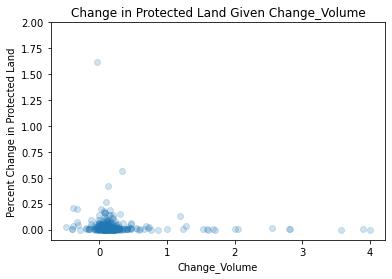

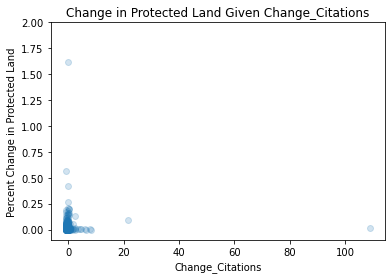

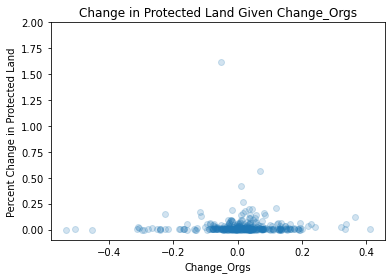

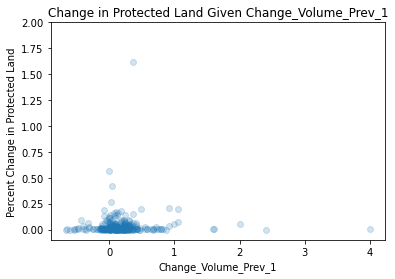

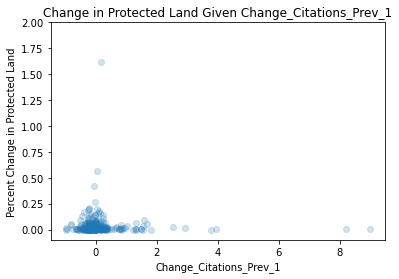

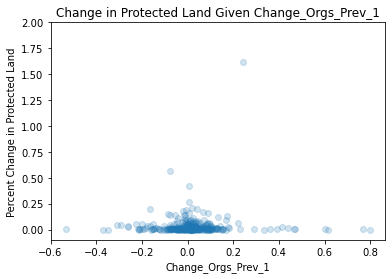

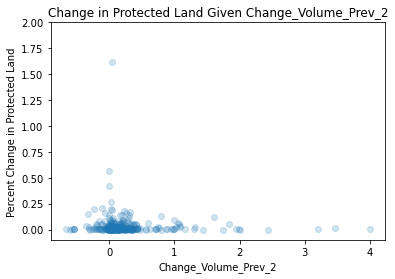

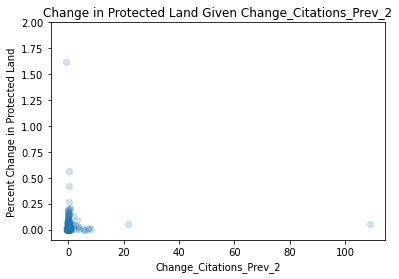

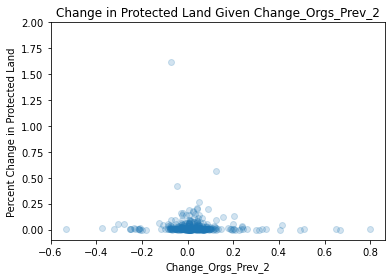

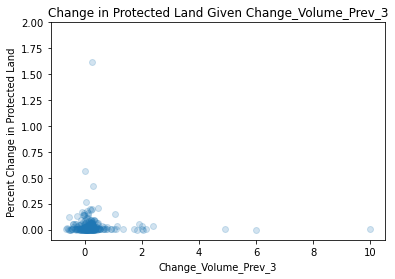

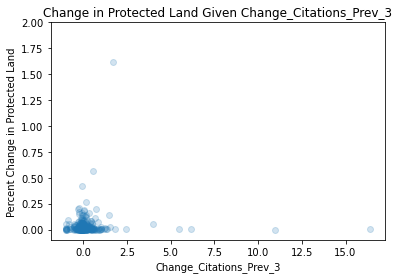

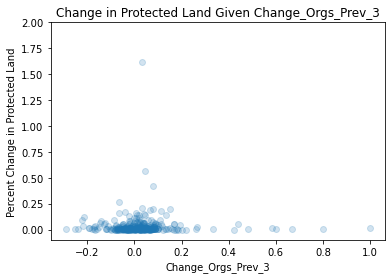

In [92]:
# visualize features vs response
import matplotlib.pyplot as plt

for column_name in X_train_increase.columns:
    plt.scatter(X_train_increase[column_name], y_increase_train, alpha=0.2)
    plt.title(f'Change in Protected Land Given {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Percent Change in Protected Land')
    plt.ylim(-0.10, 2)
    plt.show()

# Regression

## Linear

In [56]:
# run lasso regression over each country, compute the mean model and then measure performance
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# linear_regr = LinearRegression().fit(X_train_increase, np.ravel(y_increase_train))
# ridge_regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_train_increase, np.ravel(y_increase_train))
# lasso_regr = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_train_increase, np.ravel(y_increase_train))

# print(f'Linear Regression MSE: {calc_MSE(linear_regr.predict(X_test_increase), np.array(y_increase_test))}')
# print(f'Linear Regression MAE: {calc_MAE(linear_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Linear Regression R^2: {linear_regr.score(X_test_increase, y_increase_test)}')
# print(f'\nRidge Regression MSE: {calc_MSE(ridge_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Ridge Regression MAE: {calc_MAE(ridge_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Ridge Regression R^2: {ridge_regr.score(X_test_increase, y_increase_test)}')
# print(f'\nLasso Regression MSE: {calc_MSE(lasso_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Lasso Regression MAE: {calc_MAE(lasso_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Lasso Regression R^2: {lasso_regr.score(X_test_increase, y_increase_test)}')

ols_model = sm.OLS(y_increase_train, sm.add_constant(X_train_increase))
results_ols = ols_model.fit()
rlm_model = sm.RLM(y_increase_train, sm.add_constant(X_train_increase), M=sm.robust.norms.HuberT())
results_rlm = rlm_model.fit()
results_rlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               response   No. Observations:                  358
Model:                            RLM   Df Residuals:                      345
Method:                          IRLS   Df Model:                           12
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 21 Apr 2022                                         
Time:                        12:41:21                                         
No. Iterations:                    46                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0133      0.001      9.405      0.000       0.011       0.016
Change_Volume              -0.0071      0.003     -2.188      0.029      -0.014      -0.001
Change_Citations            0.0001      0.000      0.523      0.601      -0.000       0.000
Change_Orgs                 0.0118      0.010      1.151      0.250      -0.008       0.032
Change_Volume_Prev_1        0.0019      0.004      0.511      0.609      -0.005       0.009
Change_Citations_Prev_1    -0.0015      0.001     -1.164      0.244      -0.004       0.001
Change_Orgs_Prev_1          0.0020      0.011      0.182      0.856      -0.019       0.023
Change_Volume_Prev_2        0.0053      0.003      1.845      0.065      -0.000       0.011
Change_Citations_Prev_2     0.0005      0.000      2.745      0.006       0.000       0.001
Change_Orgs_Prev_2          0.0064      0.010      0.656      0.512      -0.013       0.025
Change_Volume_Prev_3        0.0018      0.003      0.692      0.489      -0.003       0.007
Change_Citations_Prev_3    -0.0013      0.002     -0.771      0.441      -0.005       0.002
Change_Orgs_Prev_3         -0.0042      0.012     -0.362      0.717      -0.027       0.018
===========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [59]:
results_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9134
Date:                Thu, 21 Apr 2022   Prob (F-statistic):              0.534
Time:                        12:45:07   Log-Likelihood:                 169.27
No. Observations:                 358   AIC:                            -312.5
Df Residuals:                     345   BIC:                            -262.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0452      0.012      3.676      0.000       0.021       0.069
Change_Volume              -0.0431      0.028     -1.523      0.129      -0.099       0.013
Change_Citations           -0.0024      0.002     -1.396      0.164      -0.006       0.001
Change_Orgs                -0.0460      0.089     -0.518      0.605      -0.221       0.129
Change_Volume_Prev_1        0.0093      0.032      0.293      0.770      -0.053       0.072
Change_Citations_Prev_1    -0.0123      0.011     -1.092      0.276      -0.035       0.010
Change_Orgs_Prev_1          0.1851      0.094      1.972      0.049       0.001       0.370
Change_Volume_Prev_2       -0.0138      0.025     -0.556      0.578      -0.062       0.035
Change_Citations_Prev_2    -0.0003      0.001     -0.185      0.853      -0.003       0.003
Change_Orgs_Prev_2          0.0539      0.084      0.638      0.524      -0.112       0.220
Change_Volume_Prev_3       -0.0343      0.023     -1.498      0.135      -0.079       0.011
Change_Citations_Prev_3     0.0216      0.014      1.500      0.135      -0.007       0.050
Change_Orgs_Prev_3          0.1501      0.100      1.496      0.136      -0.047       0.348
==============================================================================
Omnibus:                      653.665   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           309902.890
Skew:                          11.127   Prob(JB):                         0.00
Kurtosis:                     145.409   Cond. No.                         97.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
calc_MSE(results_ols.predict(sm.add_constant(X_test_increase)), y_increase_test)

0.07857584089692275

In [62]:
calc_MSE(results_rlm.predict(sm.add_constant(X_test_increase)), y_increase_test)

0.0017453612906521622

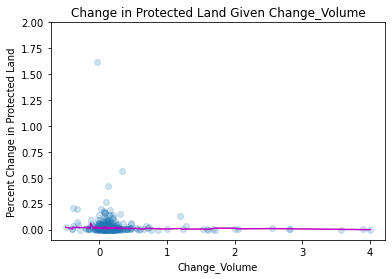

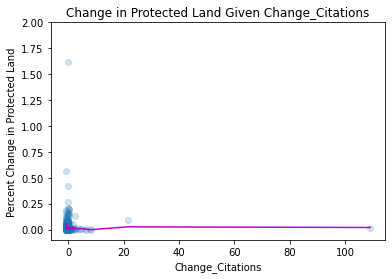

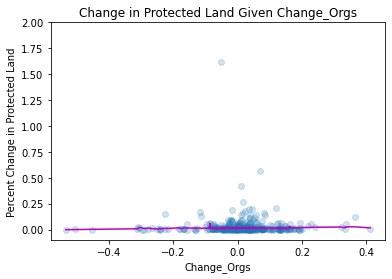

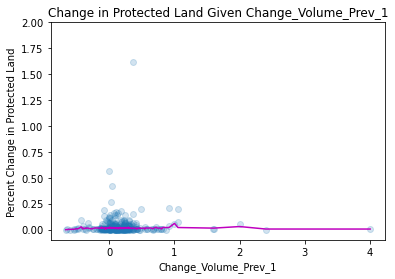

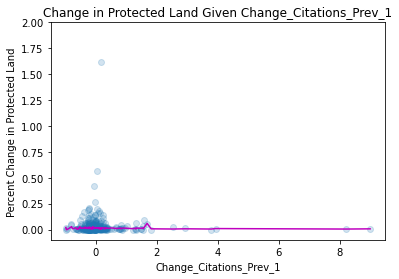

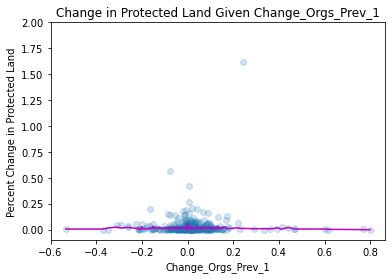

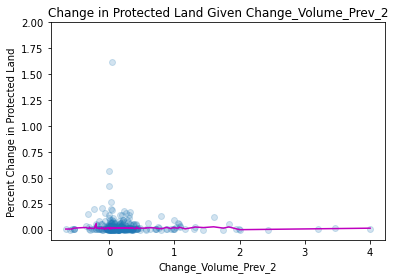

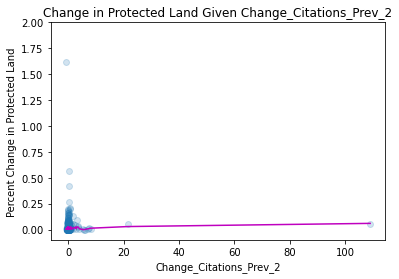

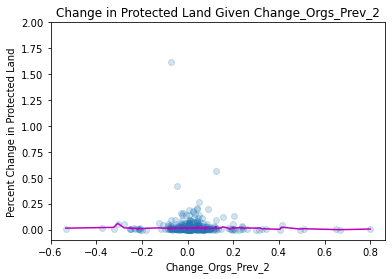

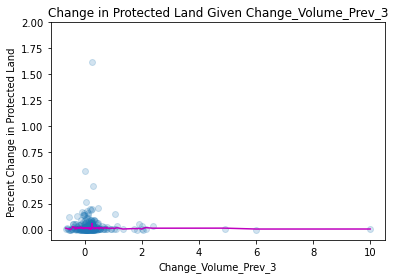

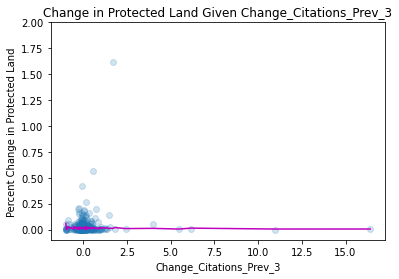

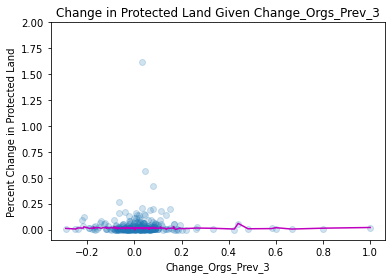

In [93]:
# robust model
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

for column_name in X_train_increase.columns:
    f = interp1d(X_train_increase[column_name], results_rlm.predict(sm.add_constant(X_train_increase)), bounds_error=False)
    y_preds = f(X_train_increase[column_name])
    X_vis, y_preds = zip(*sorted(zip(X_train_increase[column_name], y_preds)))
    plt.scatter(X_train_increase[column_name], y_increase_train, alpha=0.2)
    plt.plot(X_vis, y_preds, 'm', label='Predicted Change')
    plt.title(f'Change in Protected Land Given {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Percent Change in Protected Land')
    plt.ylim(-0.10, 2)
    plt.show()

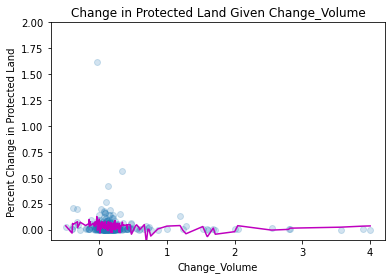

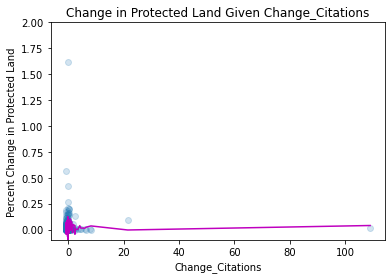

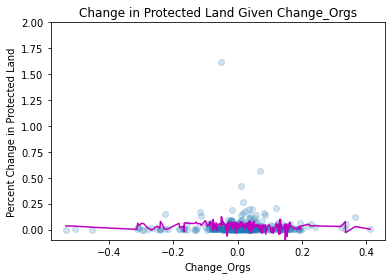

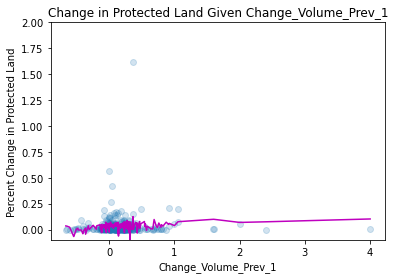

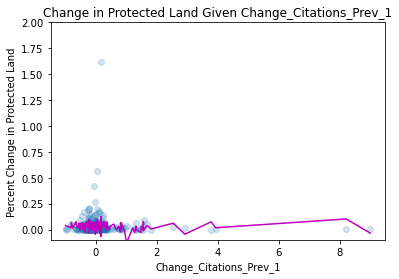

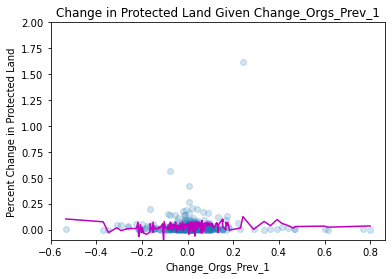

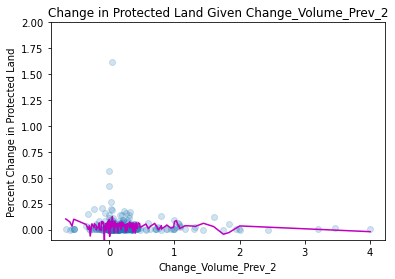

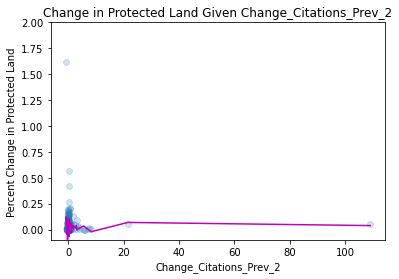

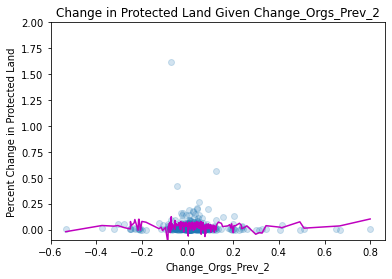

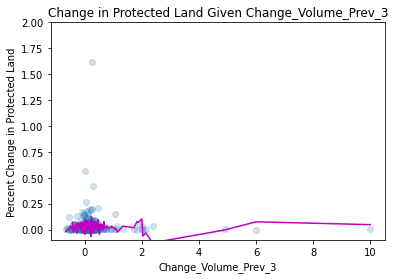

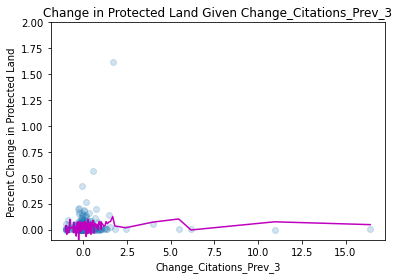

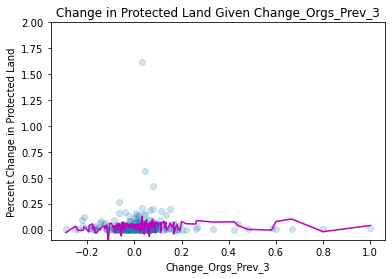

In [94]:
# OLS model
for column_name in X_train_increase.columns:
    f = interp1d(X_train_increase[column_name], results_ols.predict(sm.add_constant(X_train_increase)), bounds_error=False)
    y_preds = f(X_train_increase[column_name])
    X_vis, y_preds = zip(*sorted(zip(X_train_increase[column_name], y_preds)))
    plt.scatter(X_train_increase[column_name], y_increase_train, alpha=0.2)
    plt.plot(X_vis, y_preds, 'm', label='Predicted Change')
    plt.title(f'Change in Protected Land Given {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Percent Change in Protected Land')
    plt.ylim(-0.10, 2)
    plt.show()

In [ ]:
def confidence_interval(X, y, y_pred):
    # Covariance of coefficient estimates
    mse = np.sum(np.square(y_pred - y)) / y.size
    cov = mse * np.linalg.inv(X.T @ X)
    # Alternatively the covariance could be found using StatsModels:
    # cov = model.cov_params()

    # Calculate variance of f(x)
    var_f = np.diagonal((X @ cov) @ X.T)

    # Derive standard error of f(x) from variance
    se       = np.sqrt(abs(var_f))
    conf_int = 2*se

    return conf_int

## LOWESS

In [ ]:
from scipy.interpolate import interp1d

fraction = 0.50

X = X_train_increase['Change_Volume']
y = y_increase_train

# Fit LOWESS model
lowess = sm.nonparametric.lowess(y, X, frac=fraction)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
y_pred_lowess = f(X)

# Calculate the mean squared error
MSE = calc_MSE(y_increase_train, y_pred_lowess) #MSE of training data; Notice there was not train/test split
print('MSE is: ', MSE)

# Plot the results
plt.plot(X, y_pred_lowess, 'm')
plt.scatter(X, y)
plt.title('Change in Protetced Land Percentage Given Change_Volume')
plt.xlabel('Paper Volume')
plt.ylabel('Protected Land Percentage')
plt.show()

In [64]:
def lowess_cv(X, y, k, number_fractions_considered):
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=0) 
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]

        MSE_array = []
        interval = 1/number_fractions_considered
        fractions_considered = np.arange(interval,1+interval,interval)
        for fraction in fractions_considered:
            # Fit LOWESS model
            lowess = sm.nonparametric.lowess(y_fold_train, X_fold_train, frac=fraction, it=10)
            lowess_x = list(zip(*lowess))[0]
            lowess_y = list(zip(*lowess))[1]
            f = interp1d(lowess_x, lowess_y, bounds_error=False) 
            y_pred = f(X_fold_val)
            
            # Calculate the mean squared error
            #   If the validation set has data points outside the income range of the training set, 
            #   an error would occur in the calculation of the MSE. Therefore, validation points outside
            #   the training range are removed for this calculation
            if np.isnan(y_pred).any()==True:
                y_comparison = pd.DataFrame({'y_pred': np.array(y_pred), 'y_fold_val': np.array(y_fold_val)}, columns=['y_pred', 'y_fold_val'])
                y_comparison = y_comparison.dropna()
                MSE = mean_squared_error(y_comparison.y_fold_val, y_comparison.y_pred)
            else:
                MSE = mean_squared_error(y_fold_val, y_pred)
            MSE_array.append(MSE)

        mses[fold] = MSE_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    # Determine the minimum average MSE and with which fraction (span) does it occur
    MSE_ave_min = min(mses.mses_ave)
    span_MSE_ave_min_index = mses['mses_ave'].idxmin()
    span_MSE_ave_min = fractions_considered[span_MSE_ave_min_index]
    
    return MSE_ave_min, span_MSE_ave_min

In [65]:
def bootstrap_lowess_sample_analysis(X,y, fraction, x_array):
    x_bootstrap_min = min(X)
    x_bootstrap_max = max(X)
    
    # Fit LOWESS model
    lowess = sm.nonparametric.lowess(y, X, frac=fraction, it=10)
    lowess_x = list(zip(*lowess))[0]
    lowess_y = list(zip(*lowess))[1]
    f = interp1d(lowess_x, lowess_y, bounds_error=False)
    
    # You do no want to extrapolate the bootstrapped regression beyond the range of the bootstrap data
    # For values below the lowest income in the bootstrap sample and above the highest income in the 
    # bootstrap sample, place NaN values. 
    entries_below_bootstrap_min = sum(x_array<x_bootstrap_min)
    y_pred_below_bootstrap_min = np.full(entries_below_bootstrap_min, np.nan)

    entries_above_bootstrap_max = sum(x_array>x_bootstrap_max)
    y_pred_above_bootstrap_max = np.full(entries_above_bootstrap_max, np.nan)

    # For entries within the bootstrap sample range, used your fitted regression to predict solar installation
    incomes_within_bootstrap_data =x_array[entries_below_bootstrap_min:(len(x_array) - entries_above_bootstrap_max)]
    y_pred_within_bootstrap_data_range = f(incomes_within_bootstrap_data)

    # Concatenate the predicted solar installations for all three regions (below the lowest income in the bootstrap
    # sample, within the income data in the bootstrap sample, and above the highest income in the bootstrap sample)
    y_pred = np.concatenate((y_pred_below_bootstrap_min, y_pred_within_bootstrap_data_range, y_pred_above_bootstrap_max))

    return y_pred

In [76]:
def bootstrap_lowess_analysis(X, y,k,number_fractions_considered):
    y = y.reset_index(drop = True)
    X = np.array(X)
    x_array = np.linspace(min(X), max(X), 100, dtype=float)
        
    MSE_ave_min, span_MSE_ave_min = lowess_cv(X, y, k, number_fractions_considered)
    
    print('The average MSE across the folds when using optimal span:', MSE_ave_min)
    print('The optimal span:', span_MSE_ave_min)
    
    y_pred_bootstrap = pd.DataFrame()
    
    df = pd.concat([pd.DataFrame(X), y], axis=1)
    for i in range(0,1000):
        df_bootstrap = df.sample(n=len(df), replace=True)
        X_bootstrap  = df_bootstrap[df_bootstrap.columns[0]]
        X_bootstrap  = X_bootstrap.reset_index(drop = True)
        y_bootstrap  = df_bootstrap['response']
        y_bootstrap  = y_bootstrap.reset_index(drop = True)

        y_pred = bootstrap_lowess_sample_analysis(X_bootstrap,y_bootstrap, span_MSE_ave_min, x_array)
        y_pred_bootstrap[i] = y_pred
    
    y_pred_bootstrap_summary = pd.DataFrame()
    y_pred_bootstrap_summary['median'] = np.nanpercentile(y_pred_bootstrap, 50, axis=1)
    y_pred_bootstrap_summary['95_CI_high'] = np.nanpercentile(y_pred_bootstrap, 97.5, axis=1)
    y_pred_bootstrap_summary['95_CI_low'] = np.nanpercentile(y_pred_bootstrap, 2.5, axis=1)
    
    return y_pred_bootstrap_summary, x_array

The average MSE across the folds when using optimal span: 0.024293300023111385
The optimal span: 0.9


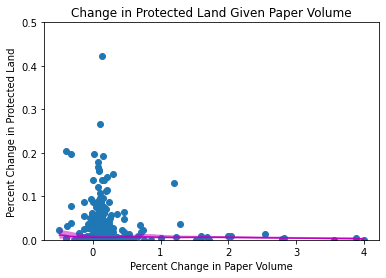

In [80]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

number_fractions_considered = 10
k = 5 #folds

[y_pred_bootstrap_summary_increase, x_array_increase] = bootstrap_lowess_analysis(X_train_increase['Change_Volume'], y_increase_train, k, number_fractions_considered)

plt.scatter(X_train_increase['Change_Volume'], y_increase_train)
plt.plot(x_array_increase, y_pred_bootstrap_summary_increase['median'], 'm')
plt.fill_between(x_array_increase, y_pred_bootstrap_summary_increase['95_CI_low'], y_pred_bootstrap_summary_increase['95_CI_high'], facecolor = 'm', alpha = 0.5)
plt.xlabel('Percent Change in Paper Volume')
plt.ylabel('Percent Change in Protected Land')
plt.title('Change in Protected Land Given Paper Volume')
plt.ylim(0, 0.5)
plt.show()

The average MSE across the folds when using optimal span: 0.02435094476834898
The optimal span: 1.0


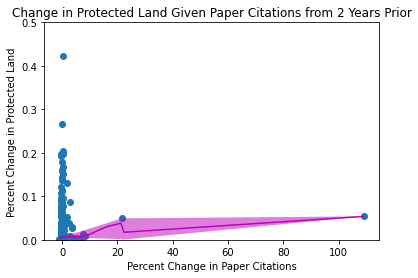

In [81]:
number_fractions_considered = 10
k = 5 #folds

[y_pred_bootstrap_summary_increase, x_array_increase] = bootstrap_lowess_analysis(X_train_increase['Change_Citations_Prev_2'], y_increase_train, k, number_fractions_considered)

plt.scatter(X_train_increase['Change_Citations_Prev_2'], y_increase_train)
plt.plot(x_array_increase, y_pred_bootstrap_summary_increase['median'], 'm')
plt.fill_between(x_array_increase, y_pred_bootstrap_summary_increase['95_CI_low'], y_pred_bootstrap_summary_increase['95_CI_high'], facecolor = 'm', alpha = 0.5)
plt.xlabel('Percent Change in Paper Citations')
plt.ylabel('Percent Change in Protected Land')
plt.title('Change in Protected Land Given Paper Citations from 2 Years Prior')
plt.ylim(0, 0.5)
plt.show()

# ARIMA

In [ ]:
# train the ARIMA model

import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# run ARIMA on Canada data from 2000 onwards
protected_df = pd.read_csv('protected_land_cleaned.csv')
canada_percentages = protected_df[protected_df['Country'] == 'Canada']
canada_percentages = canada_percentages.reset_index(drop=True)
canada_time_series = pd.DataFrame(dict({'Year': np.array(range(1950, 2022)), 'Percent_Change': np.full_like(np.arange(72), np.nan, dtype=np.double)}))

for index, raw_year in enumerate(canada_percentages['Year']):
    canada_time_series.iloc[raw_year - 1950] = [raw_year, canada_percentages['Value'].iloc[index]]

# interpolate the values
canada_time_series['Percent_Change'] = canada_time_series['Percent_Change'].interpolate()
canada_time_series['Percent_Change'] = canada_time_series['Percent_Change'].pct_change()

train, test = model_selection.train_test_split(canada_time_series['Percent_Change'][1:], train_size=0.8)


arima = pm.auto_arima(train, start_p=1, start_q=1,
                             max_p=10, max_q=10,
                             start_P=0,
                             trace=True, seasonal=False,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise


x = np.arange(test.shape[0])
plt.scatter(2021 - len(x) + x, test, color='r', marker='x', label='Actual Values')
plt.plot(2021 - len(x) + x, arima.predict(n_periods=test.shape[0]), label='Forecast')
plt.title('Actual Test Samples vs. Forecasts for Canada')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Chnage in Protected Land Percentage')
plt.show()

In [ ]:
calc_MSE(arima.predict(n_periods=test.shape[0]), np.array(canada_percentages['Value'].tail(len(test) + 1).pct_change())[1:])

Unfortunately, it appears that ARIMA methods have the lowest MSE overall

# Data Visualization

In [ ]:
import geopandas as geopandas

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['Protected Change'] = [np.nan] * len(world)
world['Change Citations'] = [np.nan] * len(world)

for i in range(len(y_train_list)):
    country_index = world.index[world['name'] == countries[i]].tolist()[0]
    world.at[country_index, 'Protected Change'] = y_train_list[i].iloc[-2]
    world.at[country_index, 'Change Citations'] = X_shifted_train_list[i]['Change_Citations'].iloc[-2]

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='Change Citations', ax=ax, missing_kwds={'color': 'lightgrey'}, legend=True, cax=cax)

In [ ]:
# correlation matrices
import seaborn as sb
import matplotlib.pyplot as plt

corr = X_train_agg.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

# Classification

In [100]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

y_train_class = np.array([1 if y_sample > 0 else 0 for y_sample in y_train_agg['Change_Protected_Percent']])
y_test_class = np.array([1 if y_sample > 0 else 0 for y_sample in y_test_agg['Change_Protected_Percent']])

X_class = pd.concat([X_train_agg, X_test_agg])
X_class = X_class.reset_index(drop=True)
y_class = np.concatenate((y_train_class, y_test_class))

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# deal with imbalanced data
over = SVMSMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [96]:
# logistic model
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

log_model = LogisticRegression().fit(X_train, y_train)
print(f'Accuracy: {log_model.score(X_test, y_test)}')
print(f'AUC: {sklearn.metrics.roc_auc_score(y_test, log_model.predict(X_test))}')

Accuracy: 0.5759493670886076
AUC: 0.6234375


In [97]:
# accuracy of naive classifier
sum(y_class)/len(y_class)

0.8114285714285714

In [114]:
# svm model
from sklearn.svm import SVC
import sklearn.metrics

svm_model = SVC(kernel='rbf', probability=True).fit(X_train, y_train)
print(f'Accuracy: {svm_model.score(X_test, y_test)}')
print(f'AUC: {sklearn.metrics.roc_auc_score(y_test, svm_model.predict(X_test))}')

Accuracy: 0.7341772151898734
AUC: 0.72109375


In [103]:
# decision tree model
from sklearn.ensemble import GradientBoostingClassifier
decision_tree = GradientBoostingClassifier(random_state=0, learning_rate=1.0, n_estimators=1000)
decision_tree = decision_tree.fit(X_train, y_train)

print(f'Accuracy: {decision_tree.score(X_test, y_test)}')
print(f'AUC: {sklearn.metrics.roc_auc_score(y_test, decision_tree.predict(X_test))}')

Accuracy: 0.7468354430379747
AUC: 0.65234375


Text(0.5, 0, 'Permutation Importance')

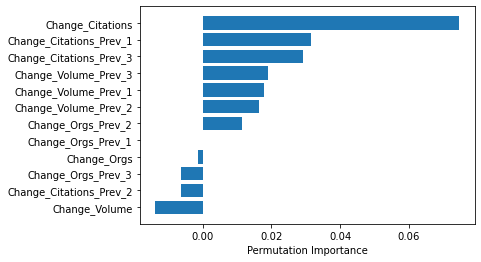

In [110]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
perm_importance = permutation_importance(svm_model, X_test, y_test)

feature_names = X_train.columns.values
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = svm_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=svm_model.classes_)
disp.plot()

In [12]:
X_train['response'] = y_train_agg
X_test['response'] = y_test_agg

X_train_increase = X_train[X_train['response'] > 0.0]
X_test_increase = X_test[X_test['response'] > 0.0]

y_increase_train = X_train_increase['response']
y_increase_test = X_test_increase['response']

X_train_increase = X_train_increase.drop(columns=['response'])
X_test_increase = X_test_increase.drop(columns=['response'])

X_train = X_train.drop(columns=['response'])
X_test = X_test.drop(columns=['response'])

In [ ]:
X_train_increase.to_csv('X_train_increase.csv')
X_test_increase.to_csv('X_test_increase.csv')
y_increase_train.to_csv('y_train_increase.csv')
y_increase_test.to_csv('y_test_increase.csv')

In [ ]:
X_train_sparse = X_train_increase[['Change_Citations', 'Change_Citations_Prev_1', 'Change_Citations_Prev_3']]

In [ ]:
X_test_sparse = X_test_increase[['Change_Citations', 'Change_Citations_Prev_1', 'Change_Citations_Prev_3']]

In [ ]:
X_train_sparse.to_csv('X_train_sparse.csv')
X_test_sparse.to_csv('X_test_sparse.csv')

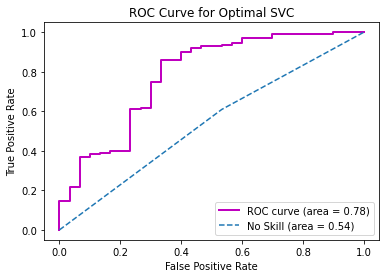

In [131]:
# plot ROC curve
y_test = np.ravel(sklearn.preprocessing.label_binarize(y_test, classes=[0, 1]))
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, svm_model.predict_proba(X_test)[:, 1])
roc_auc = sklearn.metrics.auc(fpr, tpr)

ns_probs = [1 for _ in range(len(y_test))]
ns_auc = sklearn.metrics.roc_auc_score(y_test, pos_probs)
ns_fpr, ns_tpr, _ = sklearn.metrics.roc_curve(y_test, pos_probs)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="m",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (area = %0.2f)' % ns_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Optimal SVC")
plt.legend(loc="lower right")
plt.show()

In [125]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

dumb_model = DummyClassifier(strategy='stratified')
dumb_model.fit(X_train, y_train)
yhat = dumb_model.predict_proba(X_test)
pos_probs = yhat[:, 1]
# calculate roc auc
ns_auc = roc_auc_score(y_test, pos_probs)
print('No Skill ROC AUC %.3f' % roc_auc)

No Skill ROC AUC 0.427
